In [1]:
from matplotlib import pyplot as plt

figdir = '../../figure/digital-signal-synthesis'

os.makedirs(figdir, exist_ok=True)

In [21]:
# accumulator bits
N = 8

# clock iterations
M = 50

# reference frequency
f_ref = 1e9

# output frequency
f_out = 1e8

# accumulator step
dphi = np.ceil(2**N * f_out / f_ref + .5)

# accumulator values over one period
phi = np.cumsum(dphi * np.ones(M)).astype(np.uint8)

# accumulator iterations
n = 2**N * np.linspace(0, 1, M)

# output signal
s = np.cos(2*np.pi*phi / 2**N)

In [22]:
phi.shape, n.shape

((50,), (50,))

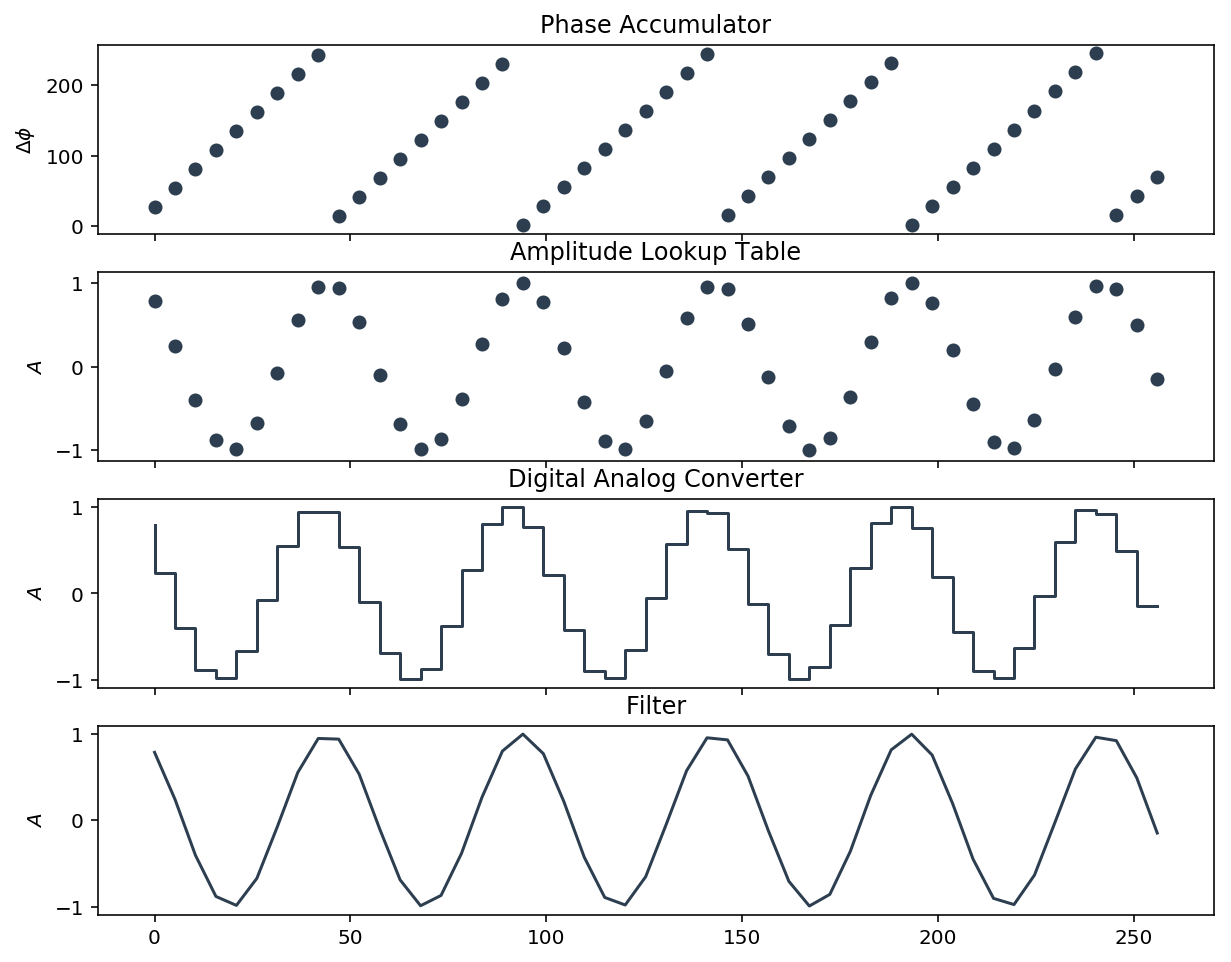

In [23]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(10, 8))

axes[0].scatter(n, phi, color='#2c3e50')
axes[0].set_title('Phase Accumulator')
axes[0].set_ylabel('$\Delta\phi$')

axes[1].scatter(n, s, color='#2c3e50')
axes[1].set_title('Amplitude Lookup Table')
axes[1].set_ylabel('$A$')

axes[2].step(n, s, color='#2c3e50')
axes[2].set_title('Digital Analog Converter')
axes[2].set_ylabel('$A$')

axes[3].plot(n, s, color='#2c3e50')
axes[3].set_title('Filter')
axes[3].set_ylabel('$A$')

plt.savefig(os.path.join(figdir, 'simple-output.pdf'))
plt.show()